In [1]:

from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from threading import Thread


In [2]:
pre_filtered_stock_list = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA','UNH', 'XOM', 'JNJ', 'TSM', 'WMT', 'V', 'JPM', 'NVDA',
              'CVX', 'LLY', 'PG', 'MA', 'HD', 'BAC', 'META', 'ABBV', 'PFE', 'KO', 'MRK', 'NVO', 'PEP', 'ASML', 'COST',
              'ORCL', 'BABA', 'TMO','AVGO', 'AZN','MCD', 'SHEL', 'CSCO'
                                                                                                             ]

In [3]:
class Stock:
    """
    Placeholder.....
    """
    # Constructor function 
    def __init__(self, ticker):
        self.ticker = ticker;
        self.yf = yf.Ticker(ticker);
        self.info = '';
        self._history_info = {};

    # toString function 
    def __str__(self):
        return self.ticker; 
    
    # Get stock ticker
    def get_ticker(self):
        return self.ticker;

    # Get stock info
    def get_info(self):
        if isinstance(self.info, str):
            return self.yf.info;
        return self.info


    # Cache other historical data into a dictionary
    def get_history_info(self, start='2016-01-01', end='2022-11-01', interval='1d'):
        # Check the input args type
        try:
            assert isinstance(start, str);
            assert isinstance(end, str);
            assert isinstance(end, str);
        except Exception :
            print("At least one input have incorrect data type. Required Args: Str Str Str");
            print(Exception.__class__, "occurred.\n");

        # Generate a key value to cache a stock's historical data into a dictionary
        key = start+end+interval;

        # If that key value has already been cached, directly return value
        if key in self._history_info:
            return self._history_info[key];
        else:
            # Calculate the historical data and cache it into the dictionary
            self._history_info[key] = self.yf.history(start=start, end=end, interval=interval);
            return self._history_info[key];



1.414


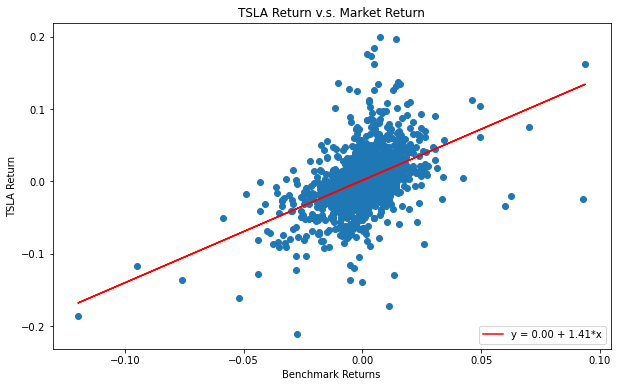

In [4]:

class StockAnalytics(Stock):
    """
    StockAnalytics extends Stock
    """
    # Constructor function 
    def __init__(self, ticker):
        Stock.__init__(self,ticker);
        self._historical_volatility = {};
        self._historical_return = {};
        self._historical_beta = {};
        self._weighted_implied_volatility = '';
        

    # toString function     
    def __str__(self):
        return self.ticker;

    def get_historical_return(self, start='2016-01-01', end='2022-11-01', interval='1d'):
        # Check the input args type
        try:
            assert isinstance(start, str);
            assert isinstance(end, str);
            assert isinstance(interval, str);
        except Exception :
            print("At least one input have incorrect data type. Required Args: Str Str Str");
            print(Exception.__class__, "occurred.\n");

        # Check if historical return is already cached
        key = start+end+interval;

        # If cached, directly return the result
        if key in self._history_info:
            return self._historical_return[key];

        try:
            # Get the historical data based on input arguments
            stock_hist = self.get_history_info(start=start, end=end, interval=interval);

            # Get the historical closing price
            prices = pd.DataFrame(stock_hist['Close']);

            # Calculate the percentage change of daily closing stock price
            daily_returns = prices.pct_change();

            # Filter out all nan values
            daily_returns = daily_returns.dropna();

            # Cache data
            self._historical_return[key] = daily_returns;

            return daily_returns
        except Exception:
            print('error: Historical return of ' + self.ticker + ' cannot be fetched');
            print(Exception.__class__, "occurred.\n");


            
    def get_historical_volatility(self, start='2016-01-01', end='2022-11-01', interval='1d'):
        # Check the input args type
        try:
            assert isinstance(start, str);
            assert isinstance(end, str);
            assert isinstance(end, str);
        except Exception :
            print("At least one input have incorrect data type. Required Args: Str Str Str");
            print(Exception.__class__, "occurred.\n");

        key = start+end+interval
        # Directly return cached value if data is already cached
        if key in self._historical_volatility:
            return self._historical_volatility[key];
        else:
            # Get historical return based on args
            historical_return = self.get_historical_return(start, end, interval);

            # Calculate daily volatility and stored it as a list
            historical_daily_volatility = historical_return.std().tolist()[0]

            # Calculate annual volatility from daily volatility (assume 250 trading days per year)
            historical_annual_volatility = historical_daily_volatility * (250 ** 0.5);

            # Round to 4 decimal places
            historical_annual_volatility = np.round(historical_annual_volatility, 4);

            # Cache annual volatility into dictionary
            self._historical_volatility[key] = historical_annual_volatility;

        return historical_annual_volatility;

    def get_historical_beta(self, market_index, start='2016-01-01', end='2022-11-01', interval='1d'):
        # Check the input args type
        try:
            assert isinstance(market_index, Stock);
            assert isinstance(start, str);
            assert isinstance(end, str);
            assert isinstance(interval, str);
        except Exception :
            print("At least one input have incorrect data type. Required Args: Stock Str Str Str");
            print(Exception.__class__, "occurred.\n");

        # Generate a key value to cache a stock's historical data into a dictionary
        key = market_index.get_ticker() + start+end+interval;

        # If that key value has already been cached, directly return value
        if key in self._historical_beta:
            return self._historical_beta[key];

        # Get historical market return and variance
        historical_market_return = market_index.get_historical_return(start, end, interval);
        historical_stock_return = self.get_historical_return(start, end, interval);
        historical_market_var = historical_market_return['Close'].var();
        historical_market_return['Stock'] = historical_stock_return['Close'];


        # Filter nan in historical_market_return
        historical_market_return = historical_market_return[historical_market_return.notnull().all(1)]

        # Get beta value
        stock_historical_beta = np.cov(historical_market_return['Close'], historical_market_return['Stock']) / historical_market_var;
        stock_historical_beta = np.round(stock_historical_beta[0][1],4);

        # Cache beta value
        self._historical_beta[key] = stock_historical_beta;

        return stock_historical_beta;

    def get_weighted_implied_volatility(self):
        """
        Calcuate the implied volatility of the stock in 1 year
        Implied volatility is obtained by calculating
        average of implied volatility from call options
        that will be matured in 1 year. The weight is determined
        by the trading volume of every call option
        :return:
        """
        # If that implied volatility has already been cached, directly return value
        if isinstance(self._weighted_implied_volatility, (float, int)):
            return self._weighted_implied_volatility;

        try:
            # Find options that will mature in about 1 yr
            for i in range((len(self.yf.options))):
                # It is hard to get options that will mature exactly in 1 yr
                # Therefore, we use the first round of maturing options in 2024
                # to estimate options maturing in 1 yr.
                if self.yf.options[i].startswith('2024'):
                    break;

            # Create a dataframe for call options maturing in early 2024
            option_info = self.yf.option_chain(self.yf.options[i]);
            option_info = pd.DataFrame().append(option_info.calls);

            # Get volume for each call options in option_info
            volume = option_info['volume'];
            volume.fillna(0, inplace=True);

            # Calculate weighted implied volatility by trading volume
            weighted_implied_volatility = np.average(option_info['impliedVolatility'], weights=option_info['volume']);
            weighted_implied_volatility = np.round(weighted_implied_volatility,4);

            # Cache implied volatility
            self._weighted_implied_volatility = weighted_implied_volatility;
            return weighted_implied_volatility;

        except Exception:
            print('Error:' + self.ticker + ' info cannot be obtained');
            print(Exception);
            
    def get_beta_scatter_plot(self, market_index, start='2016-01-01', end='2022-11-01', interval='1d'):
        # Check the input args type
        try:
            assert isinstance(market_index, Stock);
            assert isinstance(start, str);
            assert isinstance(end, str);
            assert isinstance(interval, str);
        except Exception :
            print("At least one input have incorrect data type. Required Args: Stock Str Str Str");
            print(Exception.__class__, "occurred.\n");
            
        # Get historical market return and variance
        historical_market_return = market_index.get_historical_return(start, end, interval);
        historical_stock_return = self.get_historical_return(start, end, interval);
        historical_market_return['Stock'] = historical_stock_return['Close'];
        
        # Filter nan in historical_market_return
        historical_market_return = historical_market_return[historical_market_return.notnull().all(1)]


        x = historical_market_return['Close'];
        y = historical_market_return['Stock']
        plt.figure(figsize=(10,6));
        plt.scatter(x, y , marker='o');
        plt.title(self.ticker + ' Return v.s. Market Return')
        plt.xlabel('Benchmark Returns');
        plt.ylabel(self.ticker + ' Return');
        m, b = np.polyfit(x, y, 1)
        plt.plot(x, m*x+b, color='red', label = 'y = {:.2f} + {:.2f}*x'.format(b ,m));
        plt.legend(loc='lower right')
        plt.show()
        
    def plot_implied_volatility_distribution(self):
        try:
            # Find options that will mature in about 1 yr
            for i in range((len(self.yf.options))):
                # It is hard to get options that will mature exactly in 1 yr
                # Therefore, we use the first round of maturing options in 2024
                # to estimate options maturing in 1 yr.
                if self.yf.options[i].startswith('2024'):
                    break;

            # Create a dataframe for call options maturing in early 2024
            option_info = self.yf.option_chain(self.yf.options[i]);
            option_info = pd.DataFrame().append(option_info.calls);
            price = option_info['strike'];
            volatility = option_info['impliedVolatility'];
            volume = option_info['impliedVolatility'];
            volume.fillna(0, inplace=True)
            print(option_info)
            print(volatility)

            plt.plot(price, volatility)
            plt.show();




        except Exception:
            print('Failed to graph implied volatility distribution graph');
            print('Error:' + self.ticker + ' info cannot be obtained');
            print(Exception);


market = StockAnalytics('^GSPC');
stock = StockAnalytics('TSLA');

print(stock.get_historical_beta(market_index=market));
stock.get_beta_scatter_plot(market);


In [14]:
class StockFilter:
    def __init__(self, list_of_stocks, market):
        self.list_of_stocks = list_of_stocks;
        self.market = market;
        self.market_implied_volatility = '';


    def calculate_historical_volatility(self, start='2016-01-01', end='2022-11-01', interval='1d'):
        """
        Iterate through list_of_stocks, calculate the historical_volatility for
        every stock and cache them
        :return:
        """

        # Check the input args type
        try:
            assert isinstance(start, str);
            assert isinstance(end, str);
            assert isinstance(end, str);
        except Exception :
            print("At least one input have incorrect data type. Required Args: Str Str Str");
            print(Exception.__class__, "occurred.\n");


        for i in self.list_of_stocks:
            thread = Thread(target=i.get_historical_volatility, args=(start, end, interval,));
            thread.start();
            #i.get_historical_volatility(start, end, interval);

    def calculate_historical_beta(self, start='2016-01-01', end='2022-11-01', interval='1d'):
        """
        Iterate through list_of_stocks, calculate the historical beta for
        every stock and cache them
        :return:
        """

        # Check the input args type
        try:
            assert isinstance(start, str);
            assert isinstance(end, str);
            assert isinstance(end, str);
        except Exception :
            print("At least one input have incorrect data type. Required Args: Str Str Str");
            print(Exception.__class__, "occurred.\n");


        for i in self.list_of_stocks:
            thread = Thread(target=i.get_historical_beta, args=(self.market, start, end, interval,));
            thread.start();
            #i.get_historical_beta(self.market, start, end, interval);


    def calculate_implied_volatility(self):
        """
        Iterate through list_of_stocks, calculate the historical beta for
        every stock and cache them
        :return:
        """
        for i in self.list_of_stocks:
            thread = Thread(target=i.get_historical_beta, arg=());
            thread.start();
            #i.get_weighted_implied_volatility();

    def get_weighted_implied_market_volatility(self):
        """
        Get Implied Market Volatility
        :return:
        """
        # If market's implied volatility is cached, directly return the value
        if isinstance(self.market_implied_volatility, (int, float)):
            return self.market_implied_volatility;

        # Else, calculate implied volatility
        return self.market.get_implied_volatility();

    def stock_filter(self, start='2016-01-01', end='2022-11-01', interval='1d'):
        # Check the input args type
        try:
            assert isinstance(start, str);
            assert isinstance(end, str);
            assert isinstance(end, str);
        except Exception :
            print("At least one input have incorrect data type. Required Args: Str Str Str");
            print(Exception.__class__, "occurred.\n");


        # First, filter out stocks where the difference between implied and historical
        # volatility is more than 15%
        remove_list_1 = [];
        
        for i in self.list_of_stocks:
            historical_volatility = i.get_historical_volatility();
            implied_volatility = i.get_weighted_implied_volatility();
            if ((not historical_volatility) or (not implied_volatility)):
                remove_list_1.append(i);
                continue; 
            # If there are only 25 stocks left, stop
            if (len(self.list_of_stocks) - len(remove_list_1) <= 10): break;
            elif (historical_volatility / implied_volatility >= 1.25) or \
                    (implied_volatility / historical_volatility >= 1.25):
                remove_list_1.append(i);
                

        # remove all stocks in remove_list_1
        for i in remove_list_1:
            self.list_of_stocks.remove(i)
            

        # Second, filter out stocks with beta > 1.1
        remove_list_2 = []
        
        for i in self.list_of_stocks:
            if (len(self.list_of_stocks) - len(remove_list_2) <= 10): break;
            elif (i.get_historical_beta(self.market)) > 1.1:
                remove_list_2.append(i);
                
        for i in remove_list_2:
            self.list_of_stocks.remove(i);

        return self.list_of_stocks;
    


In [15]:
# Convert list of stocks tickers into list of stocks:
def stock_ticker_to_stock_list(lst):
    list_of_stocks = [];
    for i in lst:
        list_of_stocks.append(StockAnalytics(i));
    return list_of_stocks


stock_list = stock_ticker_to_stock_list(pre_filtered_stock_list);

test = StockFilter(stock_list, StockAnalytics('^GSPC'))
for i in test.stock_filter():
    print(i);


UNH
TSM
CVX
PG
HD
ABBV
KO
PEP
COST
ORCL
AZN
MCD
CSCO


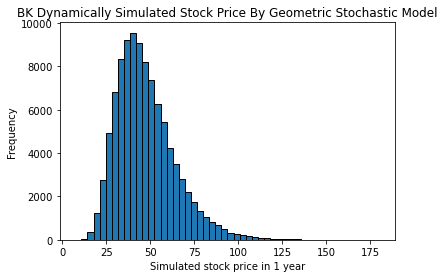

Average price after 1 year is $47.34


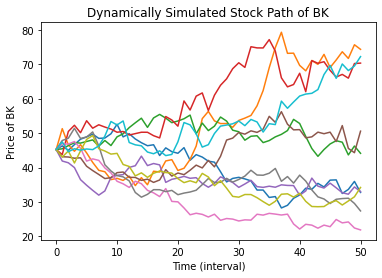

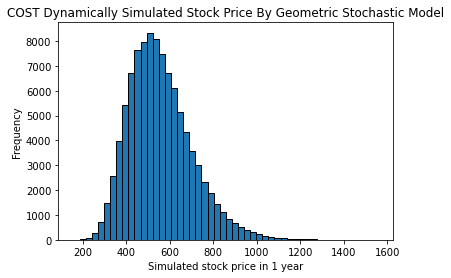

Average price after 1 year is $556.63


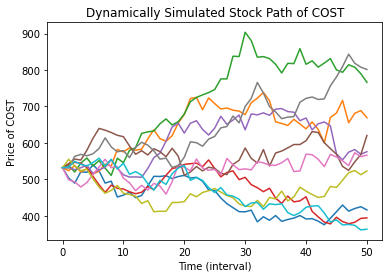

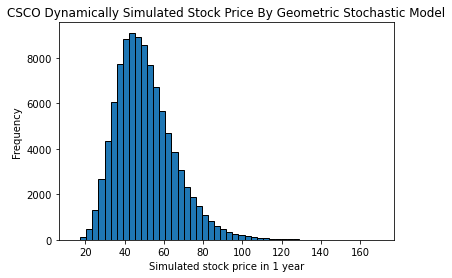

Average price after 1 year is $50.61


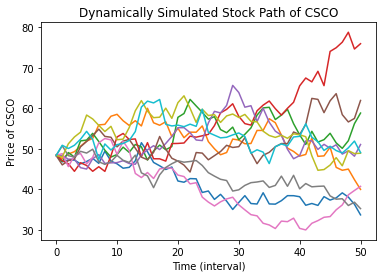

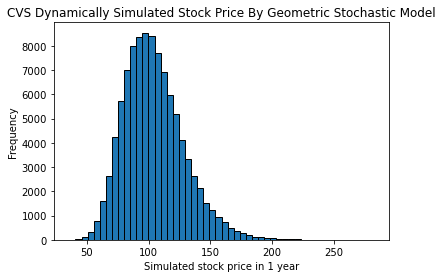

Average price after 1 year is $104.07


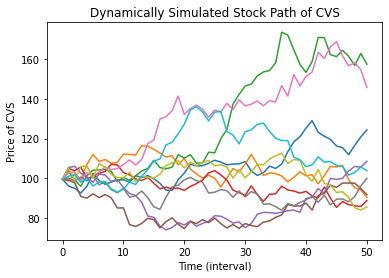

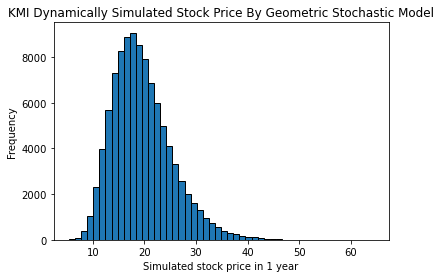

Average price after 1 year is $19.54


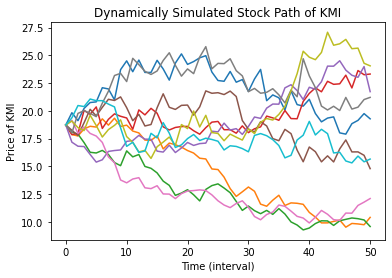

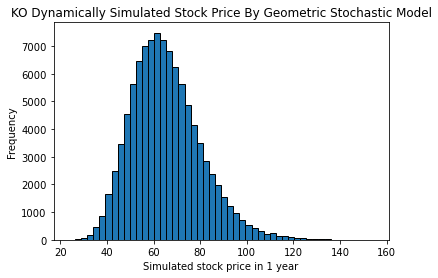

Average price after 1 year is $65.27


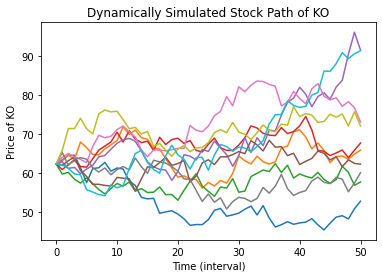

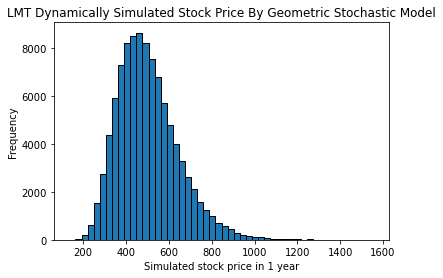

Average price after 1 year is $501.68


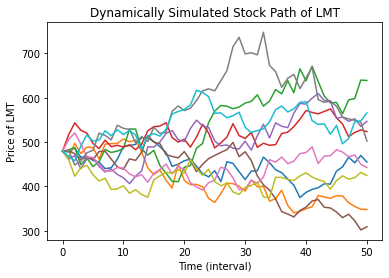

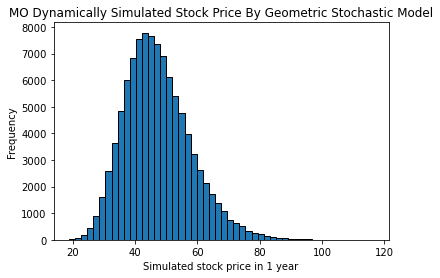

Average price after 1 year is $47.26


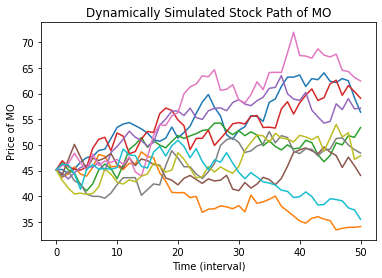

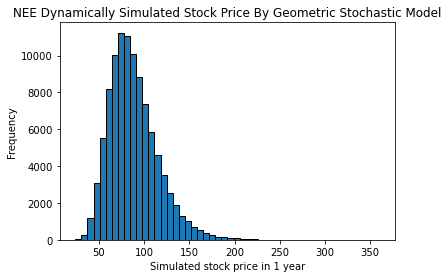

Average price after 1 year is $88.02


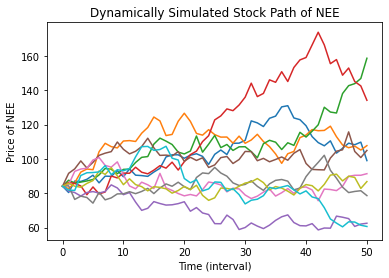

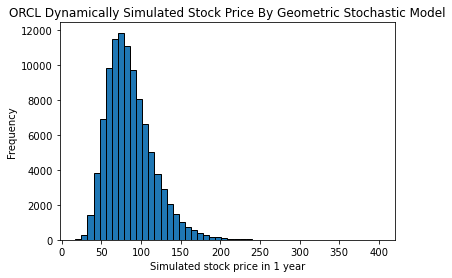

Average price after 1 year is $85.95


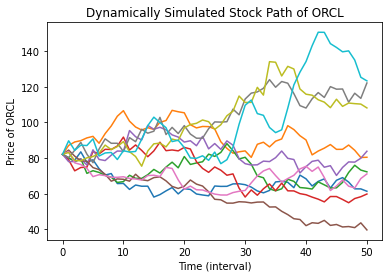

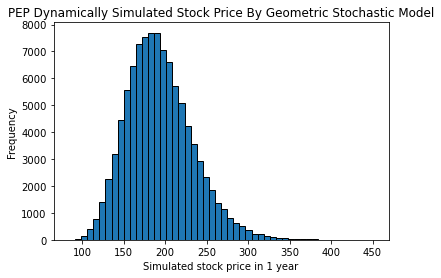

Average price after 1 year is $193.34


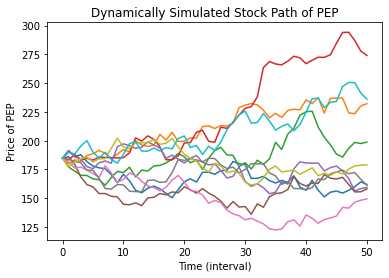

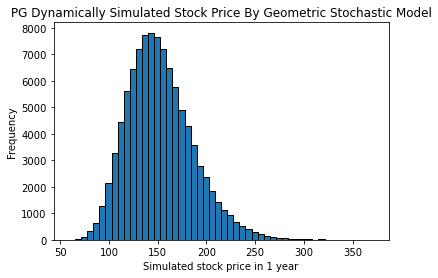

Average price after 1 year is $152.36


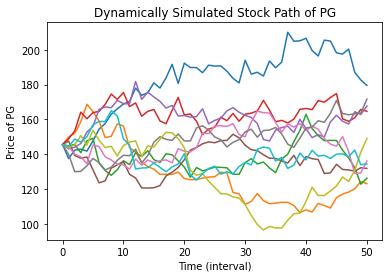

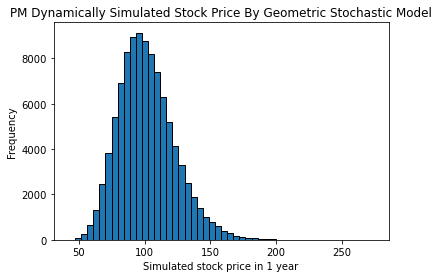

Average price after 1 year is $101.62


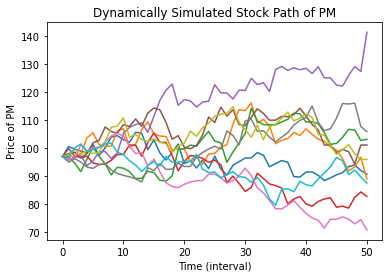

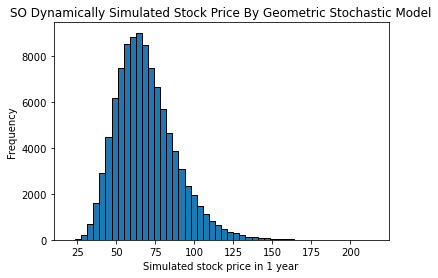

Average price after 1 year is $68.93


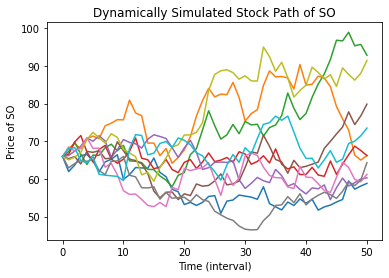

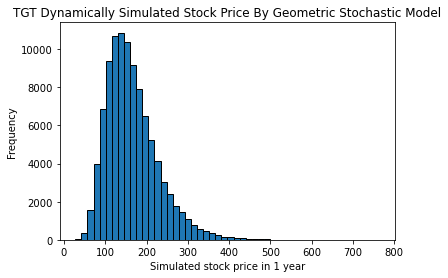

Average price after 1 year is $165.21


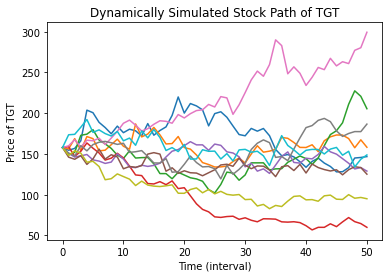

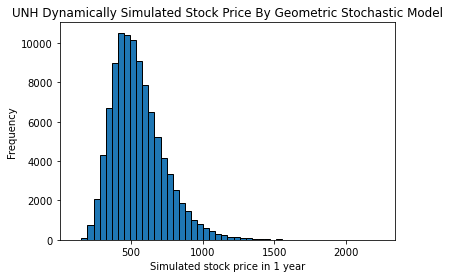

Average price after 1 year is $546.31


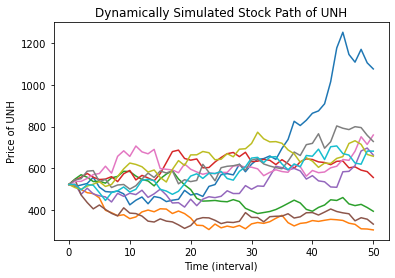

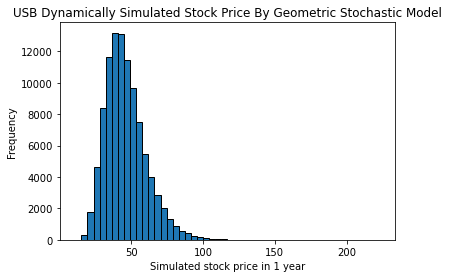

Average price after 1 year is $46.02


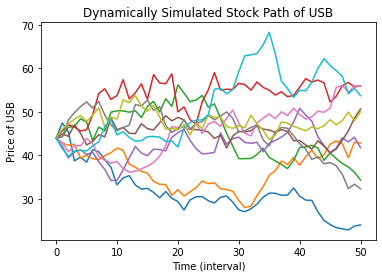

      Return
BK    1.0464
COST  1.0464
CSCO  1.0461
CVS   1.0458
KMI   1.0438
KO    1.0468
LMT   1.0463
MO    1.0465
NEE   1.0465
ORCL  1.0466
PEP   1.0460
PG    1.0463
PM    1.0459
SO    1.0452
TGT   1.0466
UNH   1.0444
USB   1.0481


In [66]:

class MonteCarloSimulation:
    def __init__(self,list_of_stocks):
        self.list_of_stocks = list_of_stocks;

    def simulation(self, stock, trials = 100000, interval=50, duration=1, r=0.045):
        # current stock price
        current_price = stock.get_info()['currentPrice'];

        # standard deviation of the stock based on implied volatility
        sigma = stock.get_weighted_implied_volatility();

        # dt is the length of each interval in terms of 1 year
        dt = duration / interval;
        # create a 2D array
        arr = np.zeros((interval + 1, trials));

        arr[0] = current_price;

        for i in range(1, interval + 1):
            arr[i] = arr[i-1] * np.exp((r - 0.5 * sigma ** 2) * dt + (sigma * np.sqrt(dt) * np.random.standard_normal(trials)));

        plt.hist(arr[-1], bins=50, ec='black');
        plt.xlabel('Simulated stock price in 1 year');
        plt.ylabel('Frequency');
        plt.title(stock.get_ticker() + ' Dynamically Simulated Stock Price By Geometric Stochastic Model')
        plt.show();

        average_terminal_price = np.round(np.mean(arr[-1]), 2);
        print('Average price after 1 year is $' + str(average_terminal_price));

        # Plot Dynamically Simulated Stock Price Path For First 10 simulation
        # To convince you our simulation works and give a good visualization of the simulation
        # we will plot the stock path for the first 10 simulation
        plt.plot(arr[:, : 10]);
        plt.title('Dynamically Simulated Stock Path of ' + stock.get_ticker());
        plt.xlabel('Time (interval)');
        plt.ylabel('Price of ' + stock.get_ticker());
        plt.show();

        average_return = np.round(average_terminal_price / current_price, 4);

        return average_return;


    def simulate_all_stocks(self):
        list_of_tickers = map(lambda x:x.get_ticker(), self.list_of_stocks); 
        stocks_after_sim = pd.DataFrame(index=list_of_tickers);
        for i in self.list_of_stocks:
            data = self.simulation(i);
            stocks_after_sim.loc[i.get_ticker(),'Return'] = data;
        return stocks_after_sim;


a = MonteCarloSimulation(stock_list);
print(a.simulate_all_stocks());


- AGN: No data found, symbol may be delisted
Error:AGN info cannot be obtained
<class 'Exception'>
- CELG: No data found, symbol may be delisted
Error:CELG info cannot be obtained
<class 'Exception'>
Error:MON info cannot be obtained
<class 'Exception'>
- PCLN: No data found for this date range, symbol may be delisted
Error:PCLN info cannot be obtained
<class 'Exception'>
- RTN: No data found, symbol may be delisted
Error:RTN info cannot be obtained
<class 'Exception'>
Error:RY.TO info cannot be obtained
<class 'Exception'>
Error:TD.TO info cannot be obtained
<class 'Exception'>
Error:TWX info cannot be obtained
<class 'Exception'>


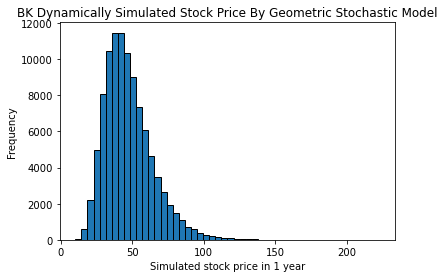

Average price after 1 year is $47.3


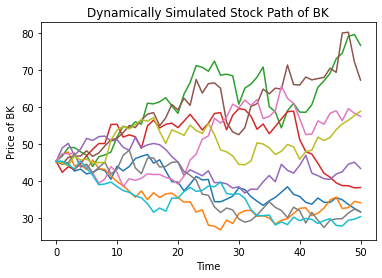

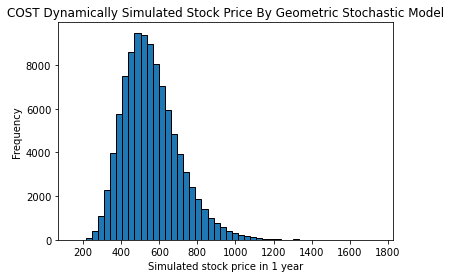

Average price after 1 year is $556.44


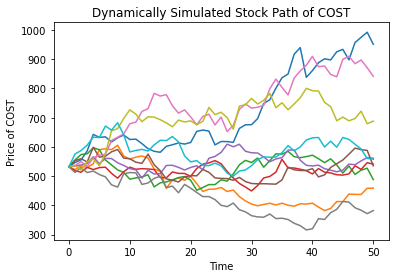

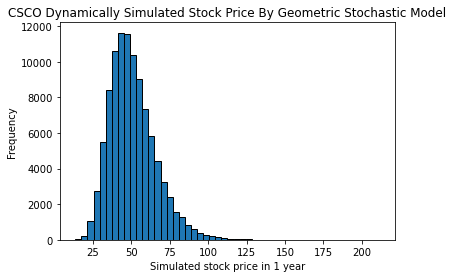

Average price after 1 year is $50.59


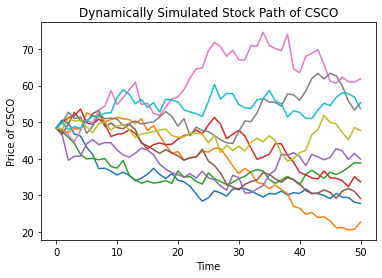

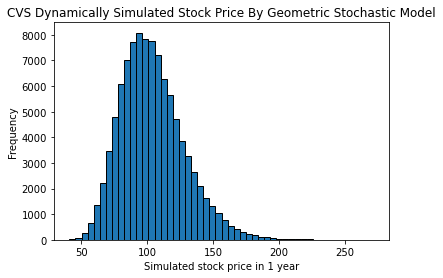

Average price after 1 year is $104.0


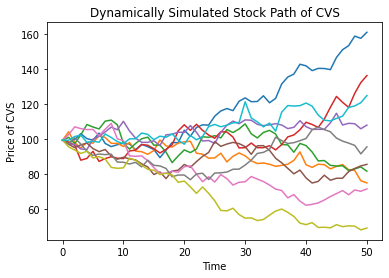

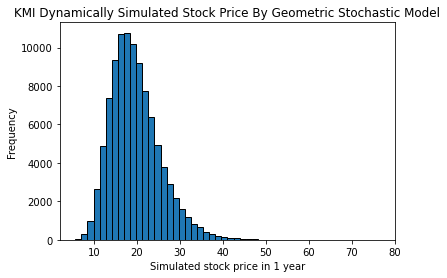

Average price after 1 year is $19.59


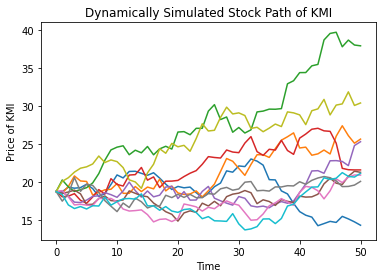

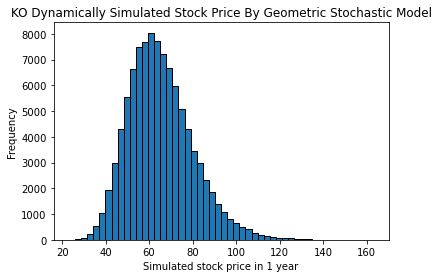

Average price after 1 year is $65.19


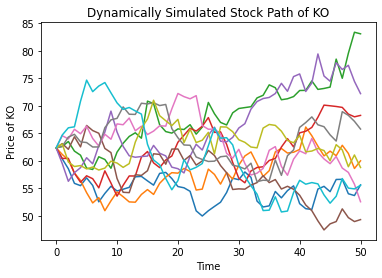

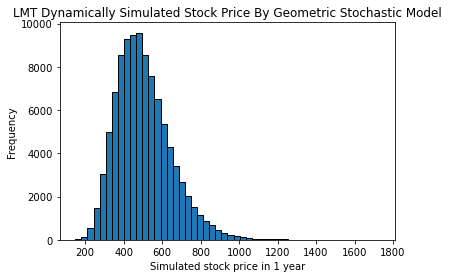

Average price after 1 year is $502.13


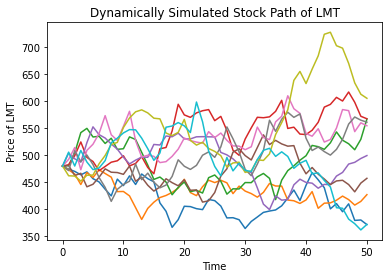

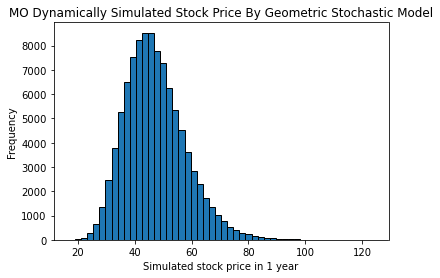

Average price after 1 year is $47.2


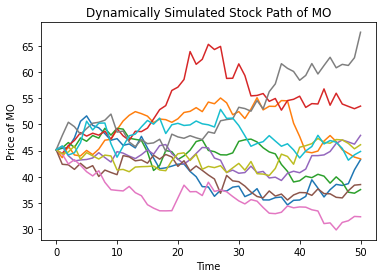

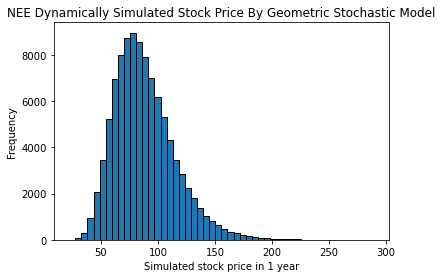

Average price after 1 year is $87.9


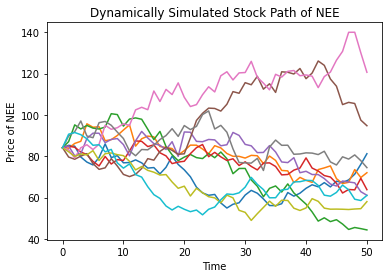

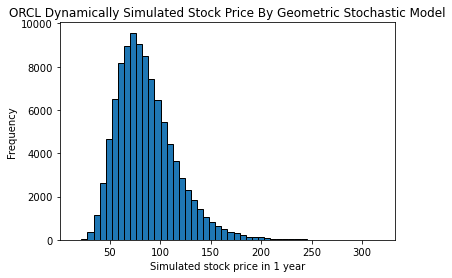

Average price after 1 year is $85.94


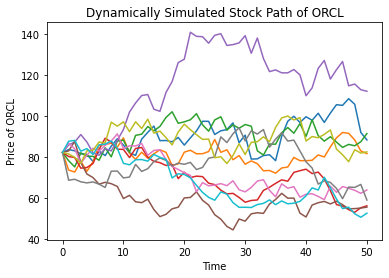

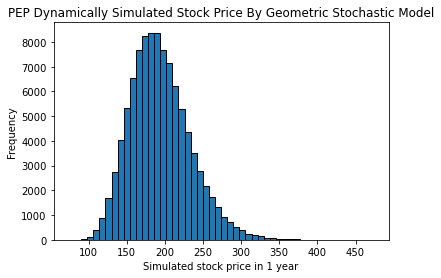

Average price after 1 year is $193.48


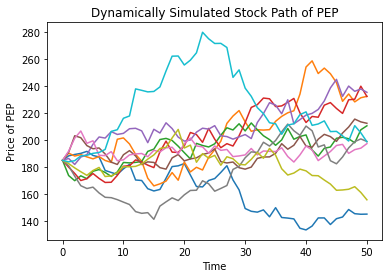

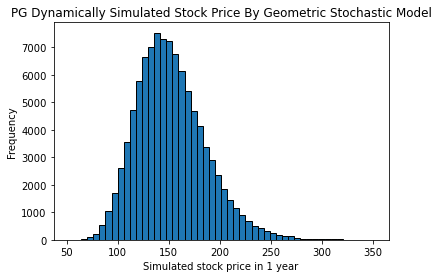

Average price after 1 year is $152.21


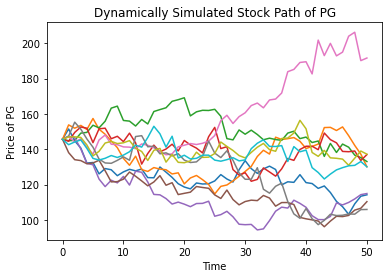

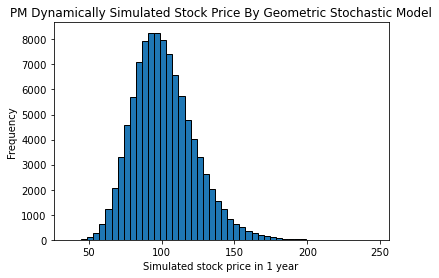

Average price after 1 year is $101.53


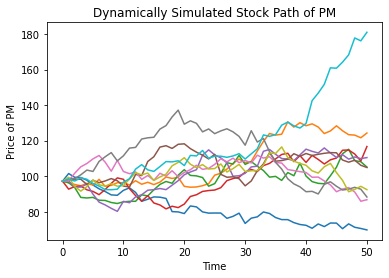

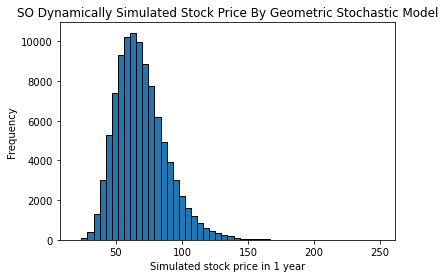

Average price after 1 year is $69.05


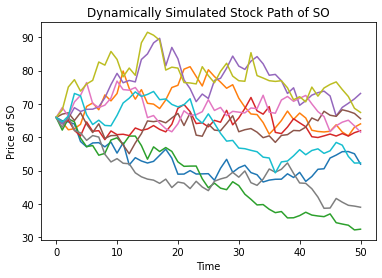

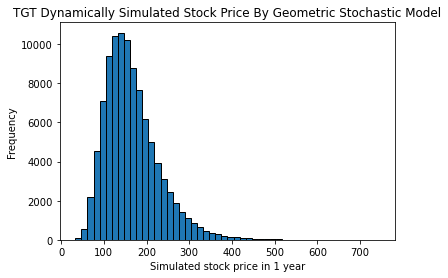

Average price after 1 year is $165.18


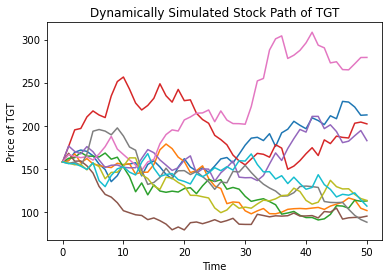

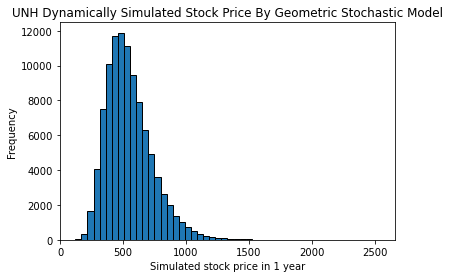

Average price after 1 year is $547.07


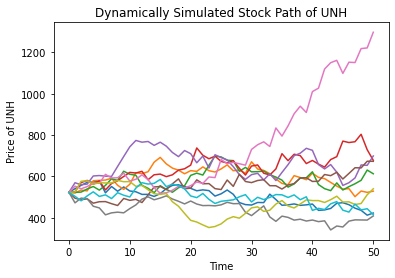

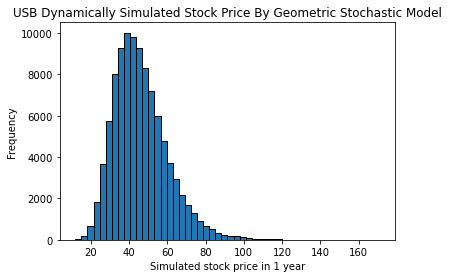

Average price after 1 year is $45.89


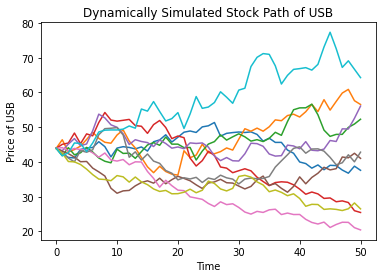

In [65]:
file = pd.read_csv('/Users/xuejingdi/Downloads/Tickers_Example.csv')
test = file['AAPL'].tolist();

stock_list = stock_ticker_to_stock_list(test);
stock_list_2 = StockFilter(stock_list, StockAnalytics('^GSPC'));
after_filter = stock_list_2.stock_filter();
simulation = MonteCarloSimulation(after_filter);
simulation.simulate_all_stocks();
